### Using frames to generate an AI Dance video for fittness

This notebook forms a third component of Dr FIT's project. A project aimed at prescribing exercise (for example, walking, yoga, basketball and so on) as a means of (energy expenditure) or in other words burning out calories consumbed (via both picture and video demostration) to counter balance energy intake (from the food 🍲 one consump). This is quite important to maintain fittness. Intially, we intended to use our database of yoga images we collected from various sources but it turns out to have way to few images to train an RNN. Therefore, we scaled up the project by generating exercise images and a dance video. I based this notebook off the modification of codes in kaggel https://www.kaggle.com/dankoliusman/how-to-teach-an-ai-to-dance/edit. While, he does uses only one video to generate an AI dance. In this note book I combined different two videos and this requires different video preprocessing approach for each. Most importantly providing much larger image database to train RNN and less chances of overfitting when more layers are added to the RNN.  

I did this notebook on Kaggle because kaggele's kernals GPU has great advantage over google colab. There is 30 hours free GPU on Kaggle, which was super helpful in this project terms of computing power. We tried using colab for many days but it has limited GPU and ones the GPU is off I has to restart the work all over again. That was very costly. Also, I tried to pay for Colab Pro but it seems not available in Belgium at moment. Therefore, to reproduce the is work, we advise using kaggle or any alternative with sufficient GPU available.

 #### Outline 
Part 1: Video Preprocessing
Part 2: Autoencoder Compression
Part 3: Train AI w/ RNNs

### Video Preprocessing
Here is the original video2: 
1.https://www.youtube.com/watch?v=w4f0Wq1o1R4
2.https://www.youtube.com/watch?v=NdSqAAT28v0

The first video is 1hour 4mins and second video is 1hour20 mins in length. The videos are somewhat similar because they contain silhouettes female dancer with similar hair length, body size, height, noand only half of the dancer's legs are shown. To this end, we generated an AI dance video that features a unique dancer, which makes it user for users of Dr FIT to follow. However, in each video the type of dance is very different. I preprocessed each video seperatelly and the combined the frames into one database before compressing with an autoencoder. 


The three parts of the notebook can be runned separately with the pretrained data by skip setting to true "True". Part one contains two sections each corresponding to preprocessing the different video. The output of the two parts was combined to form the database named "images-2images-3". This was used in part two.  

### Sources

Dance Video1: https://www.youtube.com/watch?v=w4f0Wq1o1R4 ​

Dance Video 2: https://www.youtube.com/watch?v=NdSqAAT28v0​

Proof of concept: https://www.youtube.com/watch?v=Sc7RiNgHHaE

RNN model:  https://www.kaggle.com/rishikeshnimbalkar/regenerate-dance-video?select=AI_Dance_Video.avi

RNN Article: https://www.kaggle.com/valkling/how-to-teach-an-ai-to-dance

RNN Article: The Unreasonable Effectiveness of Recurrent Neural Networks (karpathy.github.io)

RNN Article: https://keras.io/guides/working_with_rnns/#performance-optimization-and-cudnn-kernels


In [46]:
PART_1_SKIP = False
PART_2_SKIP = False
PART_3_SKIP = False

### Importing libraries and creating two zip folders. 

1. One for each video.
2. Each frame in the video is added to corressponding a zip file in sequence. 
3. Turning the image to grayscale
4. Resizing the image to 64 by 96 pixels
5. Make it binary (black & white)

In [51]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb

import os

import zipfile
z = zipfile.ZipFile("Images_1.zip", "w")
Y = zipfile.ZipFile("Images_3.zip", "w")

In [ ]:
Importing video 1

In [49]:
import cv2
cap = cv2.VideoCapture('../input/last-video/videoplayback.mp4')
print(cap.get(cv2.CAP_PROP_FPS))

29.97002997002997


Converting video 1 into frames.


In [52]:
%%time

if PART_1_SKIP == False:
    try:
        if not os.path.exists('data'):
            os.makedirs('data')
    except OSError:
        print ('Error: Creating directory of data')
 
    currentFrame = 0
    count = 0
    TRAIN_SIZE = 11447
    FRAME_SKIP = 10
    IMG_WIDTH = 96
    IMG_HEIGHT = 64
    IMG_CHANNELS = 1
    X_train = np.zeros((TRAIN_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
    
    video = cv2.VideoWriter('Simple_2_AI_Dance_Video.avi',cv2.VideoWriter_fourcc(*"MJPG"), 30, (IMG_WIDTH, IMG_HEIGHT), False)

    while(count < TRAIN_SIZE):
        try:
            ret, frame = cap.read()

            if currentFrame % FRAME_SKIP == 0:
                count += 1
                if count % int(TRAIN_SIZE/10) == 0:
                    print(str((count/TRAIN_SIZE)*100)+"% done")
                # preprocess frames
                img = frame
                img = rgb2gray(img)
                img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
                img[img > 0.5] = 255
                img[img <= 0.5] = 0
                # save frame to zip and new video sample
                name = './data/frame' + str(count) + '.jpg'
                cv2.imwrite(name, img)
                video.write(gray2rgb(img.astype('uint8')))
                Y.write(name)
                os.remove(name)
                # save image to training set if training directly to part 2
                img = img.astype('float32') / 255.
                X_train[count] = img
        except:
            print('Frame error')
            break
        currentFrame += 1

    print(str(count)+" Frames collected")
    cap.release()
    z.close()
    video.release()

9.993884860662181% done
19.987769721324362% done
29.981654581986543% done
39.975539442648724% done
49.96942430331091% done
59.963309163973086% done
69.95719402463527% done
79.95107888529745% done
89.94496374595964% done
99.93884860662182% done
Frame error
11447 Frames collected
CPU times: user 6min 32s, sys: 2min 29s, total: 9min 1s
Wall time: 4min 47s


In [ ]:
import zipfile
#z = zipfile.ZipFile("Images_1.zip", "w")
Y = zipfile.ZipFile("Images_1.zip", "w")

Importing video 2

In [42]:
import cv2
cap = cv2.VideoCapture('../input/video-2/videoplayback (1).mp4')
print(cap.get(cv2.CAP_PROP_FPS))

29.97003017816262


Converting video 2 into frames. 

In [43]:
%%time

if PART_1_SKIP == True:
    try:
        if not os.path.exists('data'):
            os.makedirs('data')
    except OSError:
        print ('Error: Creating directory of data')
 
    currentFrame = 0
    count = 0
    TRAIN_SIZE = 27000
    FRAME_SKIP = 10
    IMG_WIDTH = 96
    IMG_HEIGHT = 64
    IMG_CHANNELS = 1
    X_train = np.zeros((TRAIN_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
    
    video = cv2.VideoWriter('Simple__AI_Dance_2_Video.avi',cv2.VideoWriter_fourcc(*"MJPG"), 30, (IMG_WIDTH, IMG_HEIGHT), False)

    while(count < TRAIN_SIZE):
        try:
            ret, frame = cap.read()

            if currentFrame % FRAME_SKIP == 0:
                count += 1
                if count % int(TRAIN_SIZE/10) == 0:
                    print(str((count/TRAIN_SIZE)*100)+"% done")
                # preprocess frames
                img = frame
                img = rgb2gray(img)
                img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
                img[img > 0.5] = 255
                img[img <= 0.5] = 0
                # save frame to zip and new video sample
                name = './data/frame' + str(count) + '.jpg'
                cv2.imwrite(name, img)
                video.write(gray2rgb(img.astype('uint8')))
                z.write(name)
                os.remove(name)
                # save image to training set if training directly to part 2
                img = img.astype('float32') / 255.
                X_train[count] = img
        except:
            print('Frame error')
            break
        currentFrame += 1

    print(str(count)+" Frames collected")
    cap.release()
    z.close()
    video.release()

10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
Frame error
14387 Frames collected
CPU times: user 8min 2s, sys: 3min 5s, total: 11min 8s
Wall time: 5min 53s


### Results of Videos Preprocessing 

Video 1: output = 11447 Frames collected. First 131 frames were deleted manually from the database because they were preliminary building captions  in the video and they were completely black.

Video 2: output = 14387 Frames collected. 

Output 1 + Output 2= 11316 + 14387 = 25703 images 

1. The dancer in video 1 & 2 comes out quite clearly but a bit blocky. 
2. A binary threshold of 0.5 was a tradeoff between getting more of the dancer's pixels and picking up more dirt from the background.

### AI Dance Part 2: Autoencoder Compression

Here we are compressing the images to fit them into our RNN model. 

In [53]:
import os
import sys
import random
import warnings
from pylab import imshow, show, get_cmap

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, UpSampling2D, Flatten, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras import backend as K
import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [62]:
%%time
if PART_1_SKIP:
    IMG_WIDTH = 96
    IMG_HEIGHT = 64
    IMG_CHANNELS = 1
    INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    TRAIN_PATH = '../input/images-2images-3'
    train_ids = next(os.walk(TRAIN_PATH))[2]
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
    missing_count = 0
    print('Getting training images ... ')
#     sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH +'frame'+ str(n+1) + '.jpg'
        try:
            img = imread(path)
            img = img.astype('float32') / 255.
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
            X_train[n-missing_count] = img
        except:
            print(" Problem with: "+path)
            missing_count += 1

    print("Done! total missing: "+ str(missing_count))
else:
    INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


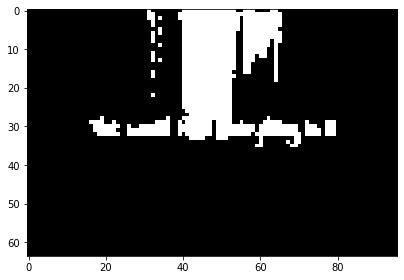

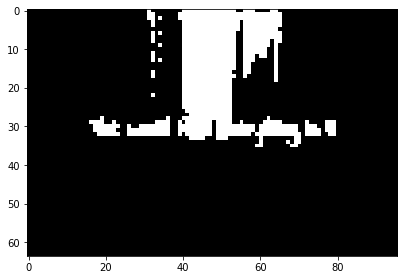

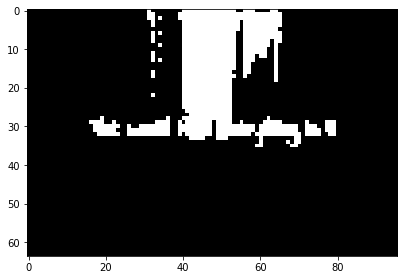

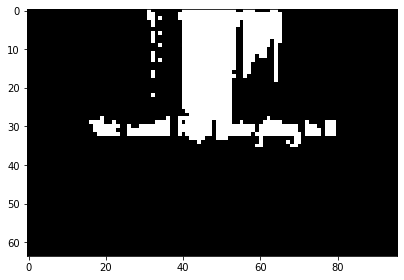

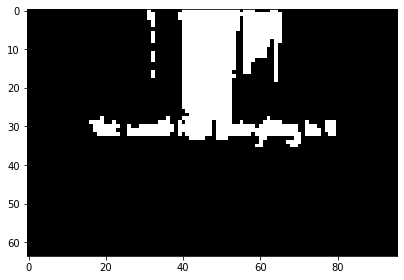

In [61]:
for n in range(10,15):
    imshow(X_train[n].reshape(IMG_HEIGHT,IMG_WIDTH))
    plt.show()

### Creating the Models

In [63]:
def Encoder():
    inp = Input(shape=INPUT_SHAPE)
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(256, activation='elu',name='encode10')(x)
    encoded = Dense(128, activation='sigmoid',name='encode11')(x)
    return Model(inp, encoded)

encoder = Encoder()
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 96, 1)]       0         
_________________________________________________________________
encode1 (Conv2D)             (None, 64, 96, 128)       2176      
_________________________________________________________________
encode2 (Conv2D)             (None, 64, 96, 64)        73792     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 48, 64)        0         
_________________________________________________________________
encode3 (Conv2D)             (None, 32, 48, 64)        36928     
_________________________________________________________________
encode4 (Conv2D)             (None, 32, 48, 32)        8224      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 24, 32)        0   

In [64]:
D_INPUT_SHAPE=[128]
def Decoder():
    inp = Input(shape=D_INPUT_SHAPE, name='decoder')
    x = Dense(256, activation='elu', name='decode1')(inp)
    x = Dense(768, activation='elu', name='decode2')(x)
    x = Reshape((4, 6, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(inp, decoded)

decoder = Decoder()
decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
decode1 (Dense)              (None, 256)               33024     
_________________________________________________________________
decode2 (Dense)              (None, 768)               197376    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 6, 32)          0         
_________________________________________________________________
decode3 (Conv2D)             (None, 4, 6, 32)          4128      
_________________________________________________________________
decode4 (Conv2D)             (None, 4, 6, 64)          18496     
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 8, 12, 64)         0   

In [65]:
def Autoencoder():
    inp = Input(shape=INPUT_SHAPE)
    x = Conv2D(128, (4, 4), activation='elu', padding='same',name='encode1')(inp)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode2')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode3')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode4')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode5')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode6')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same',name='encode7')(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same',name='encode8')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same',name='encode9')(x)
    x = Flatten()(x)
    x = Dense(256, activation='elu',name='encode10')(x)
    encoded = Dense(128, activation='sigmoid',name='encode11')(x)
    x = Dense(256, activation='elu', name='decode1')(encoded)
    x = Dense(768, activation='elu', name='decode2')(x)
    x = Reshape((4, 6, 32))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode3')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode4')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (2, 2), activation='elu', padding='same', name='decode5')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same', name='decode6')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode7')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='elu', padding='same', name='decode9')(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode10')(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same', name='decode11')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4), activation='elu', padding='same', name='decode12')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same', name='decode13')(x)
    x = Conv2D(16, (2, 2), activation='elu', padding='same', name='decode14')(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same', name='decode15')(x)
    return Model(inp, decoded)

model = Autoencoder()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 96, 1)]       0         
_________________________________________________________________
encode1 (Conv2D)             (None, 64, 96, 128)       2176      
_________________________________________________________________
encode2 (Conv2D)             (None, 64, 96, 64)        73792     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 48, 64)        0         
_________________________________________________________________
encode3 (Conv2D)             (None, 32, 48, 64)        36928     
_________________________________________________________________
encode4 (Conv2D)             (None, 32, 48, 32)        8224      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 24, 32)        0   

### Callbacks

In [66]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)

checkpoint = ModelCheckpoint("Dancer_Auto_Model.hdf5",
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=8,
                              verbose=1,
                              mode='min',
                              restore_best_weights=True)

### Custom Image Sample Callback

The sample callback tests the result of the autoencoder after every epoch by desplaying an sample image. The goal is to have the dancer come into focus as clearly as possible.

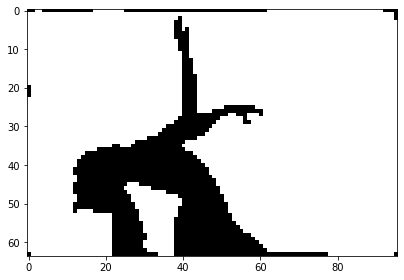

In [67]:
class ImgSample(Callback):

    def __init__(self):
       super(Callback, self).__init__() 

    def on_epoch_end(self, epoch, logs={}):
        sample_img = X_train[60]
        sample_img = sample_img.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)
        sample_img = self.model.predict(sample_img)[0]
        imshow(sample_img.reshape(IMG_HEIGHT,IMG_WIDTH))
        plt.show()


imgsample = ImgSample()
model_callbacks = [learning_rate_reduction, checkpoint, early_stopping, imgsample]
imshow(X_train[60].reshape(IMG_HEIGHT,IMG_WIDTH))

### Training Autoencoder 

Epoch 1/50
259/259 - 26s - loss: 0.0957 - val_loss: 0.0773


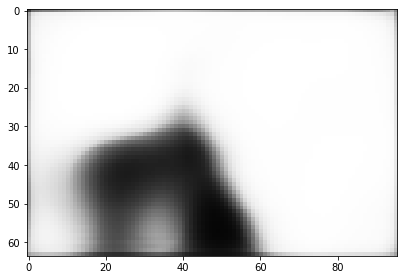

Epoch 2/50
259/259 - 20s - loss: 0.0626 - val_loss: 0.0628


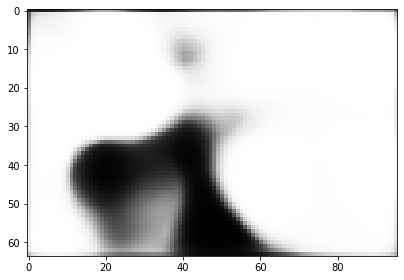

Epoch 3/50
259/259 - 20s - loss: 0.0548 - val_loss: 0.0593


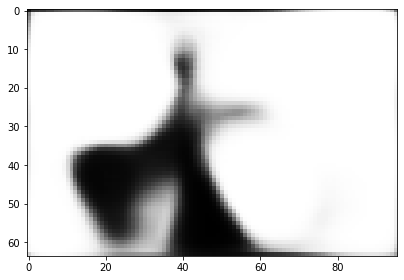

Epoch 4/50
259/259 - 20s - loss: 0.0505 - val_loss: 0.0535


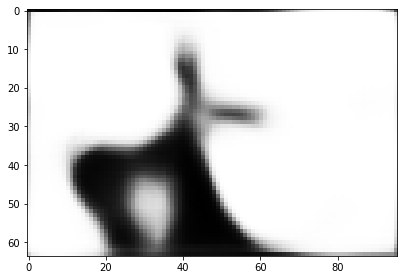

Epoch 5/50
259/259 - 20s - loss: 0.0472 - val_loss: 0.0520


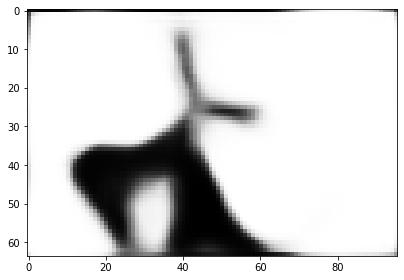

Epoch 6/50
259/259 - 20s - loss: 0.0450 - val_loss: 0.0473


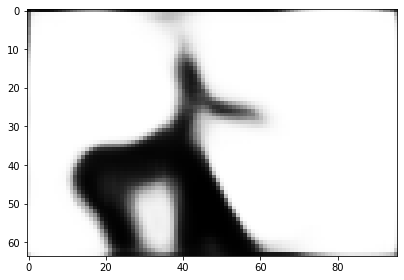

Epoch 7/50
259/259 - 20s - loss: 0.0427 - val_loss: 0.0485


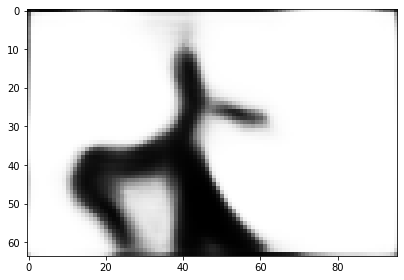

Epoch 8/50
259/259 - 20s - loss: 0.0412 - val_loss: 0.0462


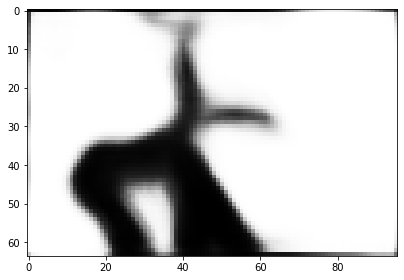

Epoch 9/50
259/259 - 20s - loss: 0.0402 - val_loss: 0.0433


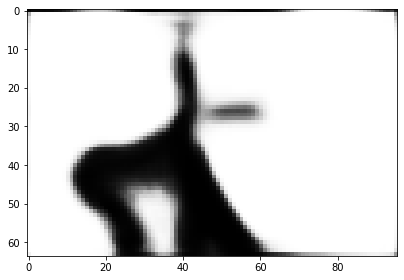

Epoch 10/50
259/259 - 20s - loss: 0.0385 - val_loss: 0.0439


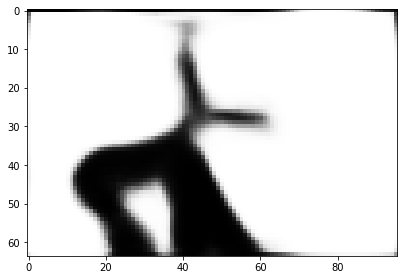

Epoch 11/50
259/259 - 20s - loss: 0.0378 - val_loss: 0.0414


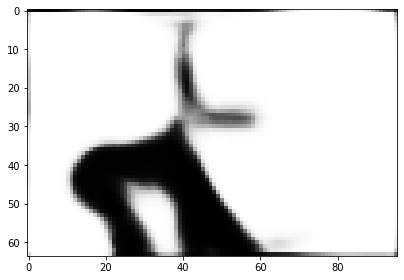

Epoch 12/50
259/259 - 20s - loss: 0.0369 - val_loss: 0.0395


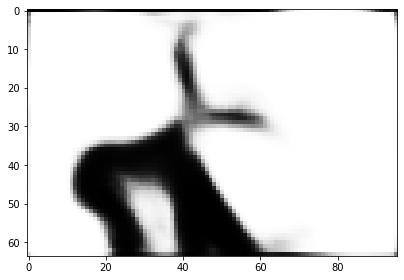

Epoch 13/50
259/259 - 20s - loss: 0.0361 - val_loss: 0.0386


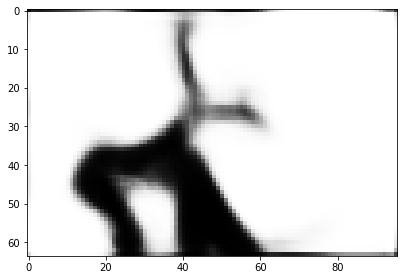

Epoch 14/50
259/259 - 20s - loss: 0.0353 - val_loss: 0.0386


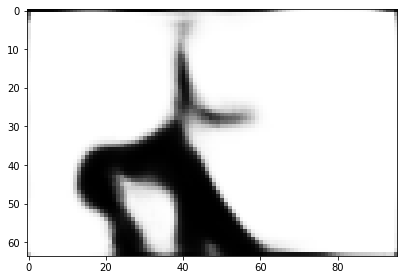

Epoch 15/50
259/259 - 20s - loss: 0.0349 - val_loss: 0.0387


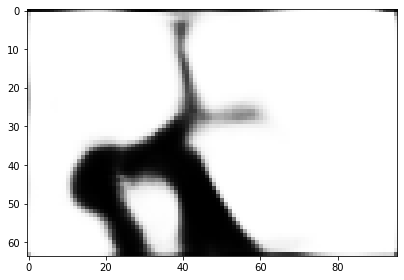

Epoch 16/50
259/259 - 20s - loss: 0.0340 - val_loss: 0.0374


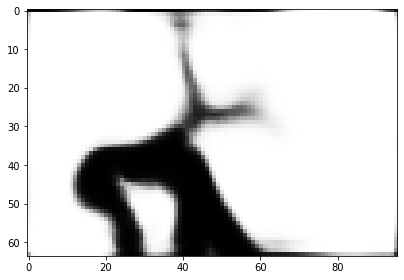

Epoch 17/50
259/259 - 20s - loss: 0.0339 - val_loss: 0.0371


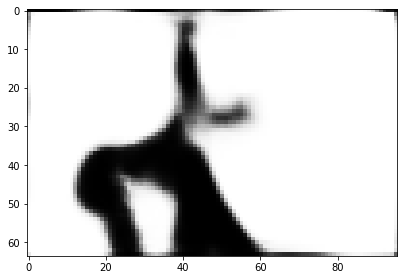

Epoch 18/50
259/259 - 20s - loss: 0.0336 - val_loss: 0.0371


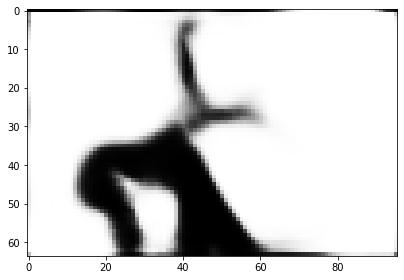

Epoch 19/50
259/259 - 20s - loss: 0.0329 - val_loss: 0.0361


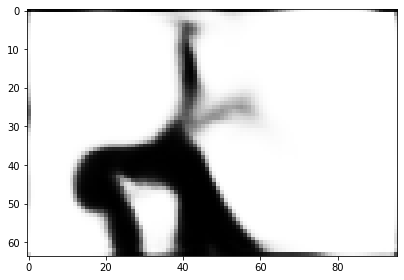

Epoch 20/50
259/259 - 20s - loss: 0.0324 - val_loss: 0.0361


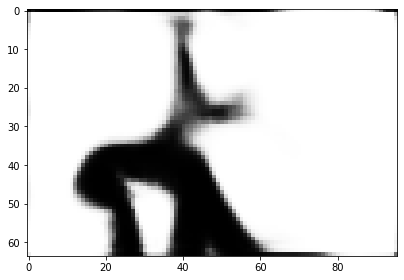

Epoch 21/50
259/259 - 20s - loss: 0.0320 - val_loss: 0.0370


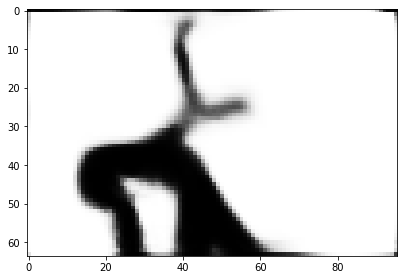

Epoch 22/50
259/259 - 20s - loss: 0.0316 - val_loss: 0.0369


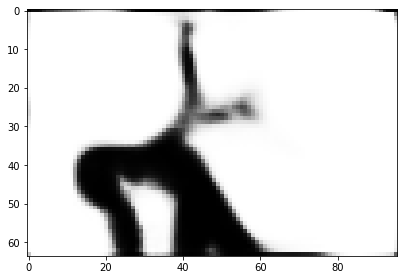

Epoch 23/50
259/259 - 20s - loss: 0.0313 - val_loss: 0.0364

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


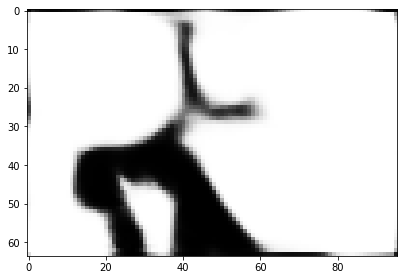

Epoch 24/50
259/259 - 20s - loss: 0.0278 - val_loss: 0.0326


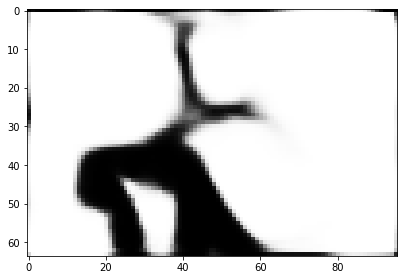

Epoch 25/50
259/259 - 20s - loss: 0.0272 - val_loss: 0.0320


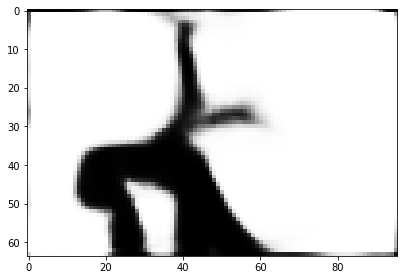

Epoch 26/50
259/259 - 20s - loss: 0.0271 - val_loss: 0.0317


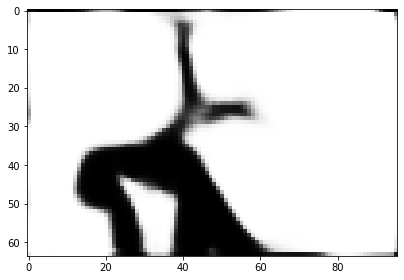

Epoch 27/50
259/259 - 20s - loss: 0.0269 - val_loss: 0.0321


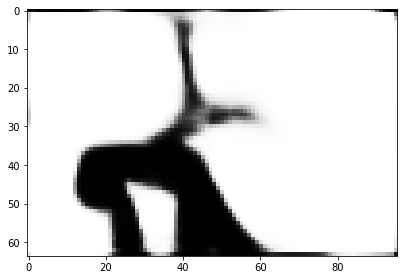

Epoch 28/50
259/259 - 20s - loss: 0.0267 - val_loss: 0.0330


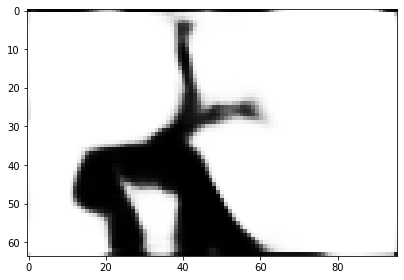

Epoch 29/50
259/259 - 20s - loss: 0.0263 - val_loss: 0.0324


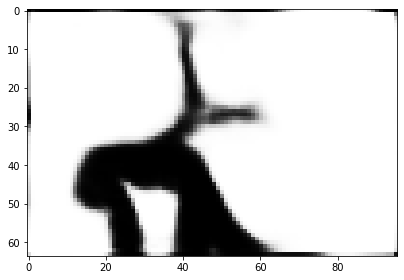

Epoch 30/50
259/259 - 20s - loss: 0.0261 - val_loss: 0.0321

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


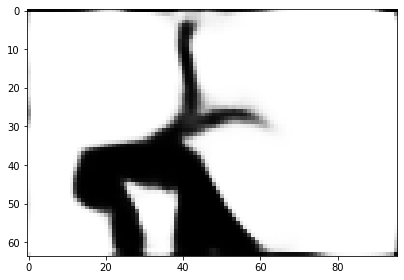

Epoch 31/50
259/259 - 20s - loss: 0.0243 - val_loss: 0.0306


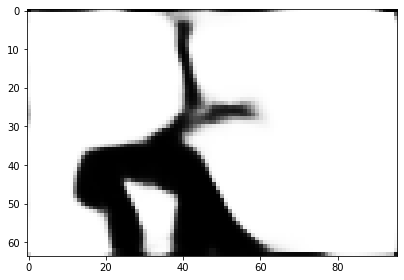

Epoch 32/50
259/259 - 20s - loss: 0.0240 - val_loss: 0.0305


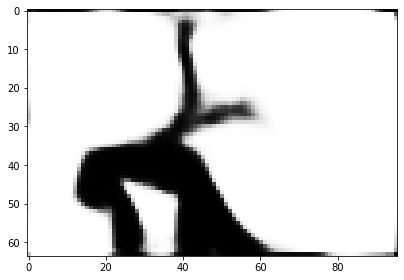

Epoch 33/50
259/259 - 20s - loss: 0.0239 - val_loss: 0.0303


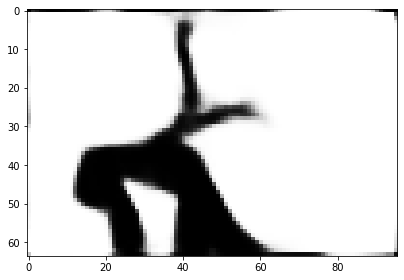

Epoch 34/50
259/259 - 20s - loss: 0.0237 - val_loss: 0.0304


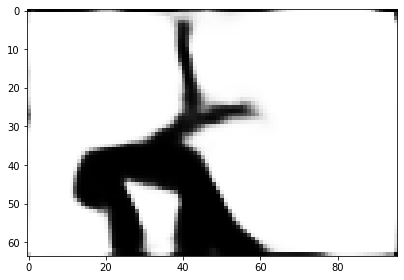

Epoch 35/50
259/259 - 20s - loss: 0.0237 - val_loss: 0.0306


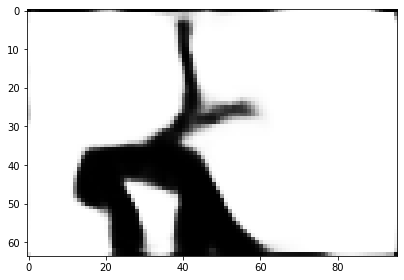

Epoch 36/50
259/259 - 20s - loss: 0.0234 - val_loss: 0.0308


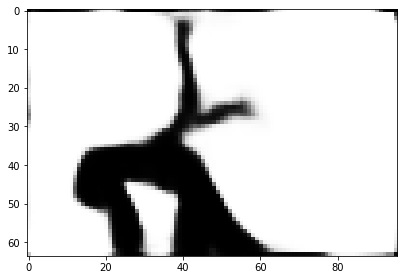

Epoch 37/50
259/259 - 20s - loss: 0.0233 - val_loss: 0.0305

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


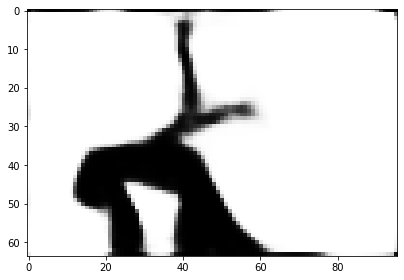

Epoch 38/50
259/259 - 20s - loss: 0.0223 - val_loss: 0.0298


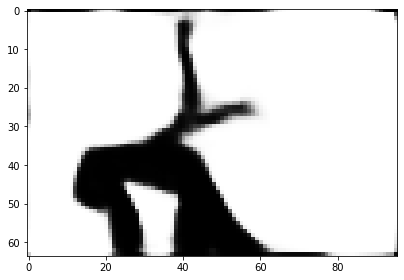

Epoch 39/50
259/259 - 20s - loss: 0.0222 - val_loss: 0.0299


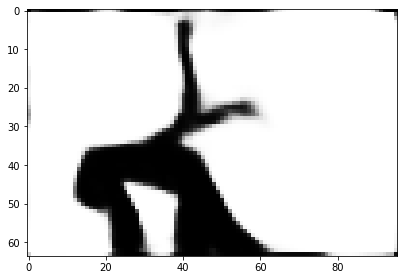

Epoch 40/50
259/259 - 20s - loss: 0.0221 - val_loss: 0.0299


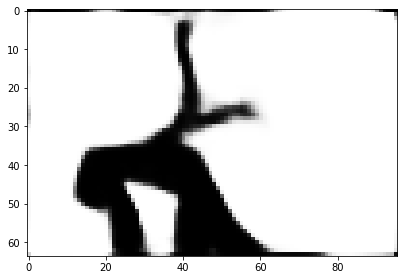

Epoch 41/50
259/259 - 20s - loss: 0.0220 - val_loss: 0.0298


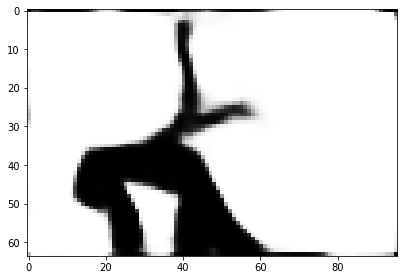

Epoch 42/50
259/259 - 20s - loss: 0.0219 - val_loss: 0.0298

Epoch 00042: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


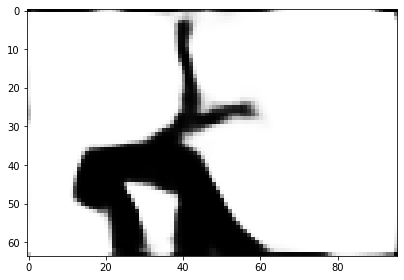

Epoch 43/50
259/259 - 20s - loss: 0.0214 - val_loss: 0.0298


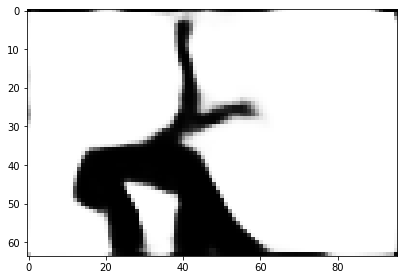

Epoch 44/50
259/259 - 20s - loss: 0.0214 - val_loss: 0.0298


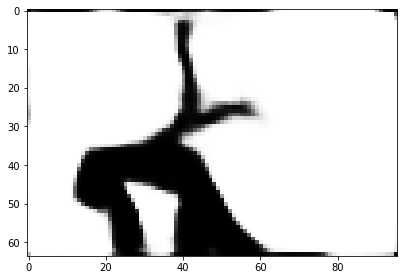

Epoch 45/50
259/259 - 20s - loss: 0.0213 - val_loss: 0.0297


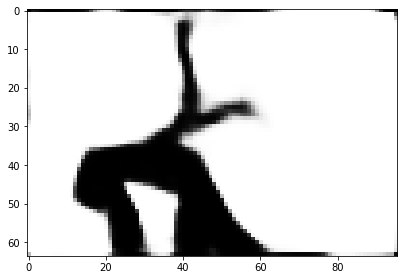

Epoch 46/50
259/259 - 20s - loss: 0.0213 - val_loss: 0.0298


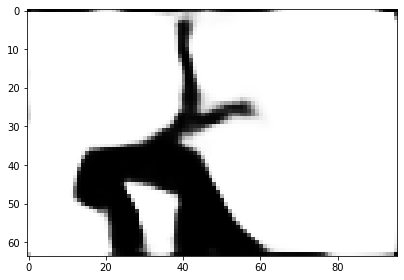

Epoch 47/50
259/259 - 20s - loss: 0.0212 - val_loss: 0.0298


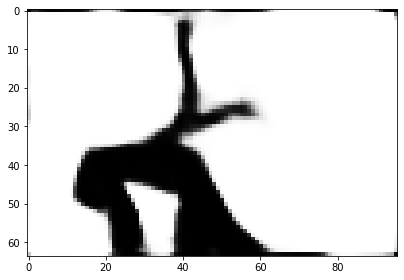

Epoch 48/50
259/259 - 20s - loss: 0.0212 - val_loss: 0.0298


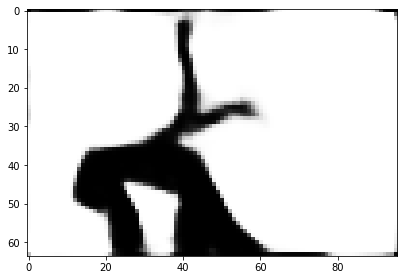

Epoch 49/50
259/259 - 20s - loss: 0.0211 - val_loss: 0.0298

Epoch 00049: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


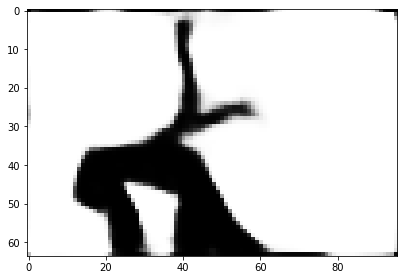

Epoch 50/50
259/259 - 20s - loss: 0.0209 - val_loss: 0.0297


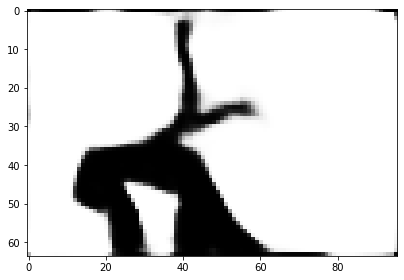

CPU times: user 3min 45s, sys: 53.4 s, total: 4min 38s
Wall time: 17min 11s


In [68]:
%%time
if PART_2_SKIP == False:
    model.fit(X_train, X_train,
              epochs=50, 
              batch_size=42,
              verbose=2,
              validation_split=0.05,
            callbacks=model_callbacks)
else:
    model = load_model('../input/Dancer_Auto_Model.hdf5')
    model.load_weights("../input/Dancer_Auto_Weights.hdf5")

In [69]:
decoded_imgs = model.predict(X_train)

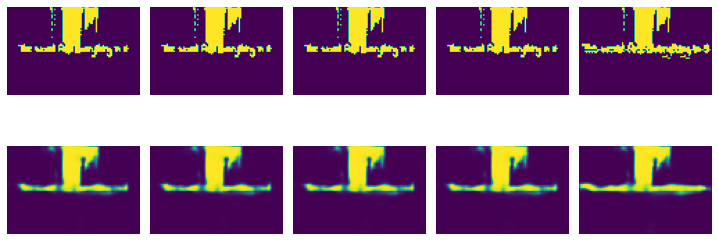

In [70]:
plt.figure(figsize=(20, 4))
for i in range(5,10):
    # original
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_train[i].reshape(IMG_HEIGHT, IMG_WIDTH))
    plt.axis('off')
 
    # reconstruction
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].reshape(IMG_HEIGHT, IMG_WIDTH))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

### Saning Models & Creating Encoding Datasets

In [71]:
model.save('Dancer_Auto_Model.hdf5')
model.save_weights("Dancer_Auto_Weights.hdf5")

In [72]:
encoder = Encoder()
decoder = Decoder()

encoder.load_weights("Dancer_Auto_Weights.hdf5", by_name=True)
decoder.load_weights("Dancer_Auto_Weights.hdf5", by_name=True)


decoder.save('Dancer_Decoder_Model.hdf5') 
encoder.save('Dancer_Encoder_Model.hdf5')

decoder.save_weights("Dancer_Decoder_Weights.hdf5")
encoder.save_weights("Dancer_Encoder_Weights.hdf5")

In [73]:
encoder_imgs = encoder.predict(X_train)
print(encoder_imgs.shape)
np.save('Encoded_Dancer.npy',encoder_imgs)

(11447, 128)


### Decoding a Sample to Double Check Results

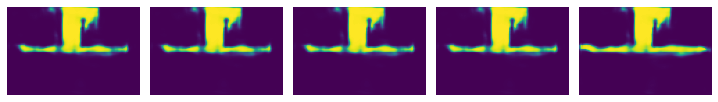

In [74]:
decoded_imgs = decoder.predict(encoder_imgs[0:11])

plt.figure(figsize=(20, 4))
for i in range(5,10):
    # reconstruction
    plt.subplot(1, 10, i + 1)
    plt.imshow(decoded_imgs[i].reshape(IMG_HEIGHT, IMG_WIDTH))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

## Part 2 Results

The results are pausable because we can encode and decode the images without issue. 

### AI Dance Part 3: Training RNNs

Here we are using our compressed pictures to make n length sequences as input that the model will use to predict the n+1 frame in the sequence. The differences are:

- The input/outputs will not be in one-hot encoding but rather an array of floats between 0 and 1

- We will need a larger brain for our model to make it work.

- We will need to decode the results after to turn them into a usable video.


In [76]:
import numpy as np
import pandas as pd
import keras as K
import random
import sqlite3
import cv2
import os

from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

from keras.layers import Input, Dropout, Dense, concatenate, Embedding
from keras.layers import Flatten, Activation
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import np_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import load_model
!pip install --upgrade keras
from keras.layers import LSTM
from keras.layers import MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

import warnings
warnings.filterwarnings('ignore')

### Little note
Here we combined both tensorlow and Keras to be able to use CuDNNLSTM for easy computation.

When processing this type of model on text data, each character is expressed in one hot arrays between ~50-100, (depending on the unique characters in the text to consider). Our data is in 128 numpy arrays, so it is not that much more load on our model to consider our compressed images over single characters of a text document.

In [78]:
if PART_2_SKIP:
    Dance_Data = np.load('./Encoded_Dancer.npy')
else:
    Dance_Data = encoder_imgs

Dance_Data.shape

(11447, 128)

### Create Compressed Dance Sequences

Our model will look at the last 70 frames and attemp to predict the 71st. As such, sur X variable will be an array of 70 (compressed) frames in sequence and our Y variable will be the 71st frame. This block chops our Dance_Data into such sequences of frames.

In [79]:
TRAIN_SIZE = Dance_Data.shape[0]
INPUT_SIZE = Dance_Data.shape[1]
SEQUENCE_LENGTH = 70

X_train = np.zeros((TRAIN_SIZE-SEQUENCE_LENGTH, SEQUENCE_LENGTH, INPUT_SIZE), dtype='float32')
Y_train = np.zeros((TRAIN_SIZE-SEQUENCE_LENGTH, INPUT_SIZE), dtype='float32')
for i in range(0, TRAIN_SIZE-SEQUENCE_LENGTH, 1 ): 
    X_train[i] = Dance_Data[i:i + SEQUENCE_LENGTH]
    Y_train[i] = Dance_Data[i + SEQUENCE_LENGTH]

print(X_train.shape)
print(Y_train.shape)

(11377, 70, 128)
(11377, 128)


### Create the RNN Model

The model is simply 6 LSTM layers stacked on top of each other. While text data only needs around 2-4 LSTM layers to work, the dance data benifits from a few more as the result is not categorical this time and a large brain allows for more "creativity"(variation) on the AIs part. (Note: CuDNNLSTM layers are just LSTM layers that automatically optimize for the GPU. They run a lot faster than standard LSTM layers at the cost of customization options)

In [80]:
def get_model():
    inp = Input(shape=(SEQUENCE_LENGTH, INPUT_SIZE))
    x = CuDNNLSTM(512, return_sequences=True,)(inp)
    x = CuDNNLSTM(256, return_sequences=True,)(x)
    x = CuDNNLSTM(512, return_sequences=True,)(x)
    x = CuDNNLSTM(256, return_sequences=True,)(x)
    x = CuDNNLSTM(512, return_sequences=True,)(x)
    x = CuDNNLSTM(1024,)(x)
    x = Dense(512, activation="elu")(x)
    x = Dense(256, activation="elu")(x)
    outp = Dense(INPUT_SIZE, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='mse',
                  optimizer=Adam(lr=0.0002),
                  metrics=['accuracy'],
                 )

    return model

model = get_model()

model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 70, 128)]         0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 70, 512)           1314816   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 70, 256)           788480    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 70, 512)           1576960   
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 70, 256)           788480    
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 70, 512)           1576960   
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 1024)              6299

### Callbacks

In [81]:
checkpoint = ModelCheckpoint("Ai_Dance_RNN_Model.hdf5",
                             monitor='loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

early = EarlyStopping(monitor="loss",
                      mode="min",
                      patience=3,
                     restore_best_weights=True)

model_callbacks = [checkpoint, early]

### Train RNN Model

In [82]:
%%time
if PART_3_SKIP == False:
    model.fit(X_train, Y_train,
              batch_size=64,
              epochs=60,
              verbose=2,
              callbacks = model_callbacks)
else:
    model = load_model('../input/Ai_Dance_RNN_Model.hdf5')
    model.load_weights('../input/Ai_Dance_RNN_Weights.hdf5')

Epoch 1/60
178/178 - 42s - loss: 0.0217 - accuracy: 0.0926

Epoch 00001: loss improved from inf to 0.02169, saving model to Ai_Dance_RNN_Model.hdf5
Epoch 2/60
178/178 - 17s - loss: 0.0180 - accuracy: 0.1348

Epoch 00002: loss improved from 0.02169 to 0.01798, saving model to Ai_Dance_RNN_Model.hdf5
Epoch 3/60
178/178 - 17s - loss: 0.0164 - accuracy: 0.1521

Epoch 00003: loss improved from 0.01798 to 0.01636, saving model to Ai_Dance_RNN_Model.hdf5
Epoch 4/60
178/178 - 17s - loss: 0.0153 - accuracy: 0.1691

Epoch 00004: loss improved from 0.01636 to 0.01529, saving model to Ai_Dance_RNN_Model.hdf5
Epoch 5/60
178/178 - 17s - loss: 0.0142 - accuracy: 0.1880

Epoch 00005: loss improved from 0.01529 to 0.01420, saving model to Ai_Dance_RNN_Model.hdf5
Epoch 6/60
178/178 - 17s - loss: 0.0133 - accuracy: 0.2019

Epoch 00006: loss improved from 0.01420 to 0.01329, saving model to Ai_Dance_RNN_Model.hdf5
Epoch 7/60
178/178 - 17s - loss: 0.0125 - accuracy: 0.2159

Epoch 00007: loss improved from 

In [83]:
model.save("Ai_Dance_RNN_Model.hdf5")
model.save_weights('Ai_Dance_RNN_Weights.hdf5')

### Generate New Computer Generated Dances

This block generates new dance sequences in the style of the video of DANCE_LENGTH size in frames. It takes a random seed pattern from the training set, predicts the next frame, adds it to the end of the pattern and drops the first frame of the pattern and predicts on the new pattern and so forth. The default DANCE_LENGTH of 6000 frames is 5 minutes of video at 20 FPS. But here we used 12000 frames for 10 minutes of video at 20 FPS. 

The LOOPBREAKER is used to add noise to the prediction pattern, replacing a random frame in the pattern with a random frame in the Dance_Data after every LOOPBREAKER frames. This noise can be used to force the AI to change up what it is doing. This can stop undertrained models from looping or overtrained models from duplication the training data too closely. Setting it too low, on the other hand, can cause the results to distort more. It is worth playing around with this setting and is a quick and dirty way to adjust the dance output post training.

In [84]:
%%time
DANCE_LENGTH  = 12000
LOOPBREAKER = 10

x = np.random.randint(0, X_train.shape[0]-1)
pattern = X_train[x]
outp = np.zeros((DANCE_LENGTH, INPUT_SIZE), dtype='float32')
for t in range(DANCE_LENGTH):
    x = np.reshape(pattern, (1, pattern.shape[0], pattern.shape[1]))
    pred = model.predict(x)
    result = pred[0]
    outp[t] = result
    new_pattern = np.zeros((SEQUENCE_LENGTH, INPUT_SIZE), dtype='float32') 
    new_pattern[0:SEQUENCE_LENGTH-1] = pattern[1:SEQUENCE_LENGTH]
    new_pattern[-1] = result
    pattern = np.copy(new_pattern)
    ####loopbreaker####
    if t % LOOPBREAKER == 0:
        pattern[np.random.randint(0, SEQUENCE_LENGTH-10)] = Y_train[np.random.randint(0, Y_train.shape[0]-1)]

CPU times: user 7min 18s, sys: 12 s, total: 7min 30s
Wall time: 7min 19s


### Output the Dance

Before we can save the video, we need to decode the frames back into images using the decoder we made in part 2.

In [85]:
if PART_2_SKIP:
    Decoder = load_model('./Dancer_Decoder_Model.hdf5')
    Decoder.load_weights('./Dancer_Decoder_Weights.hdf5')
else:
    Decoder = load_model('Dancer_Decoder_Model.hdf5')
    Decoder.load_weights('Dancer_Decoder_Weights.hdf5')

Dance_Output = Decoder.predict(outp)
Dance_Output.shape

(12000, 64, 96, 1)

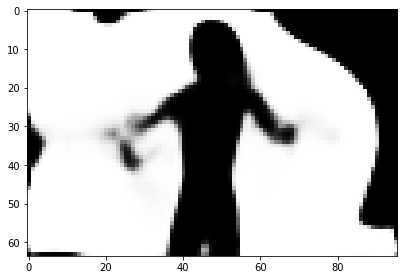

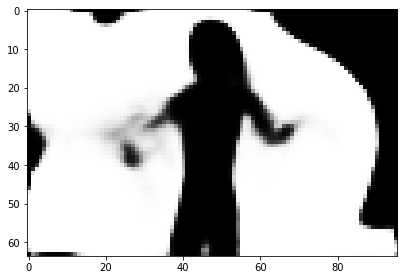

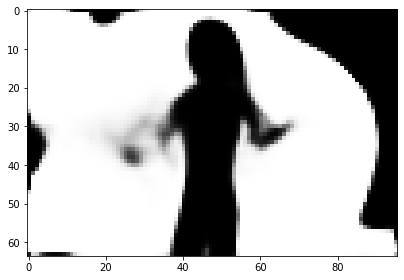

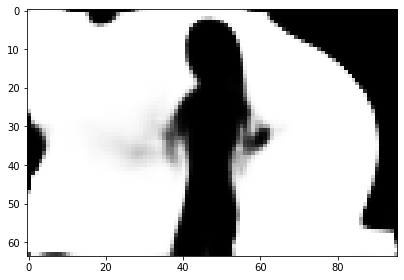

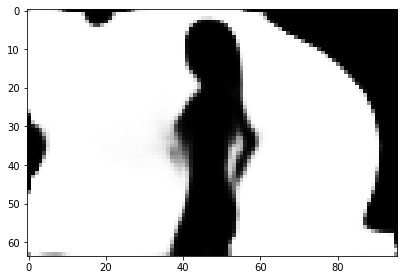

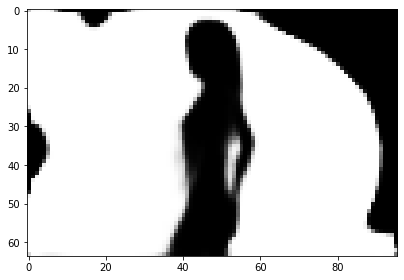

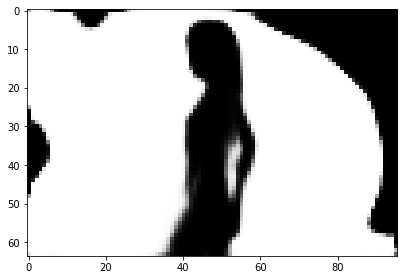

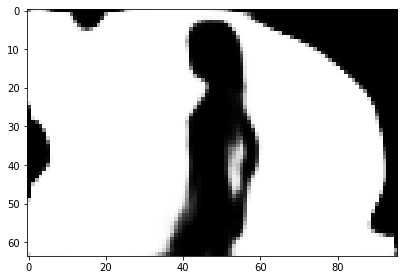

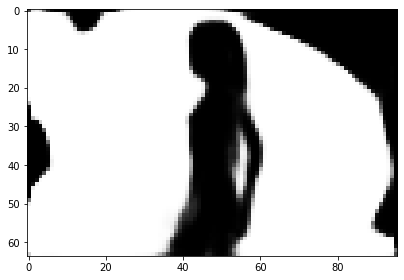

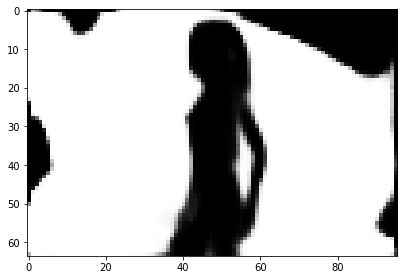

In [86]:
IMG_HEIGHT = Dance_Output[0].shape[0]
IMG_WIDTH = Dance_Output[0].shape[1]

for row in Dance_Output[0:10]:
    imshow(row.reshape(IMG_HEIGHT,IMG_WIDTH))
    plt.show()

### Save Video

In [88]:
video = cv2.VideoWriter('AI_Dance_Video.avi', cv2.VideoWriter_fourcc(*"XVID"), 20.0, (IMG_WIDTH, IMG_HEIGHT),False)

for img in Dance_Output:
    img = resize(img, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
    img = img * 255
    img = img.astype('uint8')
    video.write(img)
    #cv2.waitKey(50)
    
video.release()

### Part 3 Results

Although at about 5 to 7 minutes in the video is seems the background in the first video is not well cleaned but Even small things like the swish of the skirt or swoop of the hair are caught in the video. But there is no element of overfiting and the computer is not duplicating the dances. Interestingly, there are is variation with the original videos.  

### Possible Improvements

- The RNN model could use more and varied dances to train on. A cheap way to do this is just combining more than 2 videos.

- More layers might make the model more efficient. 

### Sources

Dance Video1: https://www.youtube.com/watch?v=w4f0Wq1o1R4 ​

Dance Video 2: https://www.youtube.com/watch?v=NdSqAAT28v0​

Proof of concept: https://www.youtube.com/watch?v=Sc7RiNgHHaE

RNN model:  https://www.kaggle.com/rishikeshnimbalkar/regenerate-dance-video?select=AI_Dance_Video.avi

RNN Article: https://www.kaggle.com/valkling/how-to-teach-an-ai-to-dance

RNN Article: The Unreasonable Effectiveness of Recurrent Neural Networks (karpathy.github.io)

RNN Article: https://keras.io/guides/working_with_rnns/#performance-optimization-and-cudnn-kernels
